<a href="https://colab.research.google.com/github/QuadV/ImplementingPapers/blob/main/AttentionIsAllYouNeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

**Multi-Head Attention**

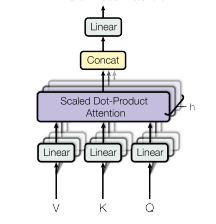

**Scaled Dot-Product Attention**

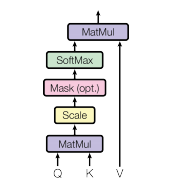

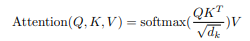

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size  # 256
    self.heads = heads  # 8 heads
    self.head_dim = embed_size//heads  # 32

    assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

    # Linear layers to send Values, Keys and Queries
    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
    # concatenate the three outputs
    self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

  def forward(self, values, keys, query, mask):
      N = query.shape[0] # number of training examples
      value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

      # split embeddings into heads pieces
      values = values.reshape(N, value_len, self.heads, self.head_dim)  #  Initially in (batch_size, length_of_val, embed_size)
      keys = keys.reshape(N, key_len, self.heads, self.head_dim)
      queries = query.reshape(N, query_len, self.heads, self.head_dim)

      values = self.values(values)
      keys = self.keys(keys)
      queries = self.queries(queries)

      #  multiply queries with keys
      energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
      # queries shape: (N, query_len, self.heads, self.head_dim)
      # keys shape: (N, key_len, self.heads, self.head_dim)
      # energy_shape: (N, heads, query_len, key_len) # how much attention should be paid for for each word in the sentence
      
      if mask is not None:
        energy = energy.masked_fill(mask==0, float("-1e20")) # if it is masked, set it to -infinity (numerical value is set to prevent overflow)
      
      attention = torch.softmax(energy/(self.embed_size ** (1/2)), dim=3)  # dim=3, normalizing across the key length
      # key is the source sentence, query is target. The scores along keys are normalized. If first word = 0.8, it means attentiion along that word is high

      out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
          N, query_len, self.heads * self.head_dim
      )
      # attention shape: (N, heads, query_len, key_len)  # key_len and value_len are same
      # values shape: (N, value_len, heads, self.head_dim)
      # out shape: (N, query_len, heads, head_dim) then flatten last two dimensions

      out = self.fc_out(out)
      return out


**Transformer Block**

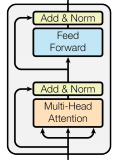

**Feed Forward**

image.png

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(embed_size=embed_size, heads=heads)
    self.norm1 = nn.LayerNorm(embed_size)  # takes an average for every single example rather than batch-wise
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),  # forward_expansion=4 in paper
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, value, key, query, mask):
    attention = self.attention(value, key, query, mask)

    x = self.dropout(self.norm1(attention + query))  # input query are passed as well - skip connection
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out

**Encoder**

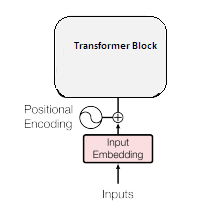

In [ ]:
class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(num_embeddings=src_vocab_size, embedding_dim=embed_size)
    self.position_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_size)

    self.layers = nn.ModuleList(
        [
          TransformerBlock(embed_size=embed_size, heads=heads, dropout=dropout, forward_expansion=forward_expansion) for _ in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)  # value, key, query are same inputs

    return out


**Decoder**

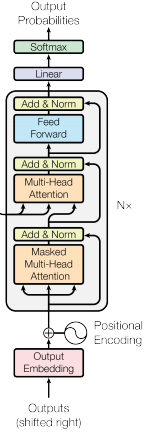

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, query, src_mask, trg_mask):
    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out

class Decoder(nn.Module):
  def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
         DecoderBlock(embed_size=embed_size, heads=heads, forward_expansion=forward_expansion, dropout=dropout, device=device) for _ in range(num_layers)
        ]
    )
    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x)+self.position_embedding(positions)))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(x)
    return out



In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=512, num_layers=6, forward_expansion=4,
               heads=8, dropout=0, device="cuda", max_length=100):
    super(Transformer, self).__init__()
    self.encoder = Encoder(
        src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length
    )
    self.decoder = Decoder(
        trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length
    )
    self.src_pad_idx =src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # (N, 1, 1, src_len)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out

In [ ]:
if __name__ == '__main__':
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
  trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

  src_pad_idx = 0
  trg_pad_idx = 0
  src_vocab_size = 10
  trg_vocab_size = 10
  model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)

  out = model(x, trg[:, :-1])
  print(out.shape)

torch.Size([2, 7, 10])
